In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.tree import DecisionTreeClassifier

In [2]:
white_wine_trans = pd.read_csv('transformed_wine_data/white_wine_trans.csv')
red_wine_trans = pd.read_csv('transformed_wine_data/red_wine_trans.csv')
X_white = white_wine_trans.drop(['quality_label', 'quality', 'type'], axis = 1)
y_white = white_wine_trans['quality_label']

In [3]:
X_red = red_wine_trans.drop(['quality_label', 'quality', 'type'], axis = 1)
y_red = red_wine_trans['quality_label']

<h3> Random Forest Approach </h3>

<h3> Red Wine </h3>

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_red, y_red, test_size=0.3, random_state=101)

In [5]:
from sklearn.ensemble import RandomForestClassifier

<h5> Try with default settings </h5>

In [6]:
# Use 10 random trees
model = RandomForestClassifier(n_estimators=10,max_features='auto',random_state=101)
model.fit(X_train,y_train)
preds = model.predict(X_test)

In [7]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

        high       0.33      0.20      0.25         5
         low       0.00      0.00      0.00        24
lower_middle       0.69      0.75      0.71       208
      middle       0.57      0.65      0.60       180
upper_middle       0.56      0.37      0.44        63

    accuracy                           0.62       480
   macro avg       0.43      0.39      0.40       480
weighted avg       0.59      0.62      0.60       480



<h3> Explore hyper parameters </h3>

<h5> Play with number of trees </h5>

In [8]:
test_error = []

for n in range(1,100):
    # Use n random trees
    model = RandomForestClassifier(n_estimators=n,max_features=3)           # Choose from 3 features at each node. (approx. sqrt(num. features))
    model.fit(X_train,y_train)
    test_preds = model.predict(X_test)
    test_error.append(1-accuracy_score(test_preds,y_test))
 

run time = 12 s

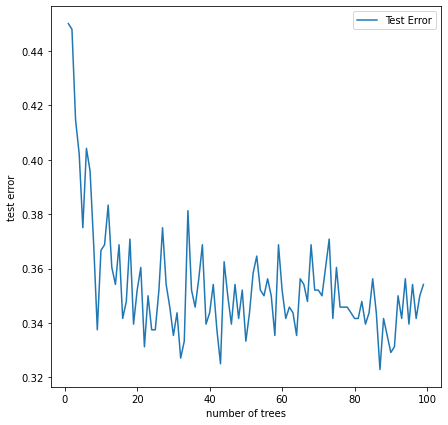

In [9]:
plt.figure(figsize = (7,7))
plt.plot(range(1,100),test_error,label='Test Error')
plt.xlabel('number of trees')
plt.ylabel('test error')
plt.legend()

Looks like we can get error down to around 34% <br>
Point of diminishing returns is at around 20–50. <br>
Remember: random forest will not overfit, so increasing the number of trees won't worsen the model. <br>
Let's set num_trees = 50 for now, and move on to exploring the max features.

In [11]:
f1_scores = []

for n in range(1,100):
    # Use n random trees
    model = RandomForestClassifier(n_estimators=n,max_features=3)           # Choose from 3 features at each node. (approx. sqrt(num. features))
    model.fit(X_train,y_train)
    
    test_preds = model.predict(X_test)

    score = f1_score (y_test, test_preds, average = 'macro')

    f1_scores.append(score)
 

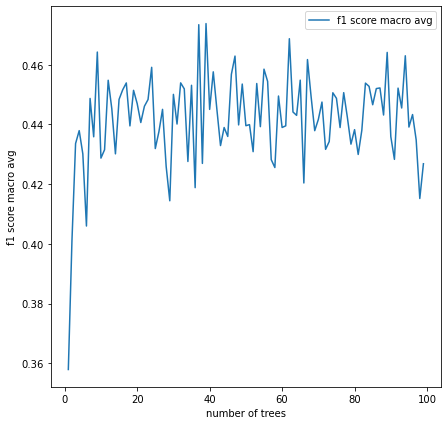

In [12]:
plt.figure(figsize = (7,7))
plt.plot(range(1,100),f1_scores,label='f1 score macro avg')
plt.xlabel('number of trees')
plt.ylabel('f1 score macro avg')
plt.legend()

Looks like f1 score macro avg tops out at around 45%

<h5> Play with max_features </h5>

In [13]:
test_error = []

for n in range(1,11):               # Upper limit must be 10, since we have 11 features. (n =11 would be regular decision tree, which we want to exclude)
    # Use n random trees
    model = RandomForestClassifier(n_estimators=50,max_features=n)           
    model.fit(X_train,y_train)
    test_preds = model.predict(X_test)
    test_error.append(1-accuracy_score(test_preds,y_test))

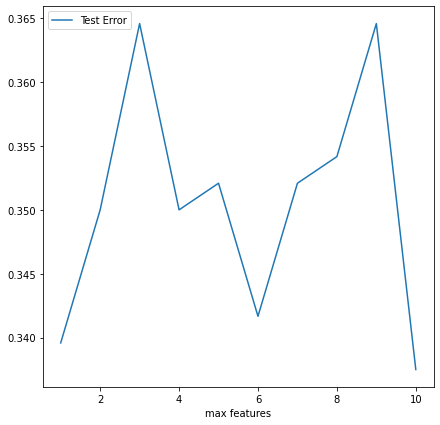

In [14]:
plt.figure(figsize = (7,7))
plt.plot(range(1,11),test_error,label='Test Error')
plt.xlabel('max features')
plt.legend()

Test error doesn't fluctuatte that wildly. Good to know. <br>
Two or three random features actually must be optimal. <br>
For grid search, may as well try from 2 to 10.

In [15]:
f1_scores = []

for n in range(1,11):
    # Use n random trees
    model = RandomForestClassifier(n_estimators=50,max_features=n)           # Choose from 3 features at each node. (approx. sqrt(num. features))
    model.fit(X_train,y_train)
    
    test_preds = model.predict(X_test)

    score = f1_score (y_test, test_preds, average = 'macro')

    f1_scores.append(score)
 

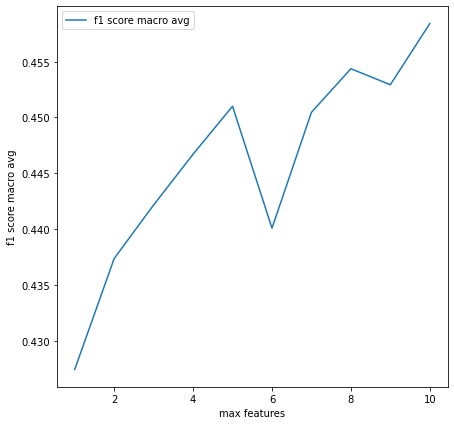

In [17]:
plt.figure(figsize = (7,7))
plt.plot(range(1,11),f1_scores,label='f1 score macro avg')
plt.xlabel('max features')
plt.ylabel('f1 score macro avg')
plt.legend()

More features generally seems to do better. For gridsearch, may sa well do all from 2 to 10

<h3> Grid search for best combination of hyper parameters </h3>

In [22]:
n_estimators=[10,30,50,70,90,110,130,150]
max_features= [2,3,4, 6, 7, 8, 9]
bootstrap = [True,False]

In [23]:
param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap} 

<h5> First do grid search for highest (pure) accuracy </h5>

In [24]:
rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid, scoring = ('f1_micro'))

# f1_micro = regular accuracy. 
# f1_macro = unweighted average of all f1 values for all classes.
# If we care about predicting the outliers accurately, f1_macro is important.

In [25]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_features': [2, 3, 4, 6, 7, 8, 9],
                         'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150]},
             scoring='f1_micro')

run time = 1 min 48 s

In [26]:
cv_results_f1_micro = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

In [27]:
cv_results_f1_micro.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.074555,0.000291,0.005136,0.000095,True,3,50,"{'bootstrap': True, 'max_features': 3, 'n_esti...",0.718750,0.665179,0.633929,0.669643,0.744395,0.686379,0.039735,1
5,0.137676,0.001062,0.009069,0.000105,True,2,110,"{'bootstrap': True, 'max_features': 2, 'n_esti...",0.714286,0.696429,0.642857,0.656250,0.721973,0.686359,0.031460,2
38,0.299408,0.002557,0.010245,0.000218,True,7,130,"{'bootstrap': True, 'max_features': 7, 'n_esti...",0.687500,0.669643,0.665179,0.647321,0.753363,0.684601,0.036681,3
7,0.186773,0.000883,0.011819,0.000251,True,2,150,"{'bootstrap': True, 'max_features': 2, 'n_esti...",0.674107,0.683036,0.665179,0.665179,0.730942,0.683688,0.024537,4
43,0.176962,0.001147,0.006380,0.000183,True,8,70,"{'bootstrap': True, 'max_features': 8, 'n_esti...",0.674107,0.678571,0.669643,0.638393,0.753363,0.682816,0.037994,5
22,0.216753,0.001385,0.010238,0.000271,True,4,130,"{'bootstrap': True, 'max_features': 4, 'n_esti...",0.709821,0.674107,0.651786,0.633929,0.735426,0.681014,0.037174,6
55,0.409784,0.002267,0.011821,0.000711,True,9,150,"{'bootstrap': True, 'max_features': 9, 'n_esti...",0.691964,0.683036,0.642857,0.651786,0.735426,0.681014,0.032848,7
27,0.146836,0.000866,0.006485,0.000200,True,6,70,"{'bootstrap': True, 'max_features': 6, 'n_esti...",0.691964,0.674107,0.642857,0.660714,0.730942,0.680117,0.030081,8
21,0.183813,0.001840,0.008986,0.000075,True,4,110,"{'bootstrap': True, 'max_features': 4, 'n_esti...",0.687500,0.683036,0.660714,0.633929,0.730942,0.679224,0.032100,9
62,0.184235,0.001723,0.010801,0.000251,False,2,130,"{'bootstrap': False, 'max_features': 2, 'n_est...",0.674107,0.678571,0.642857,0.669643,0.730942,0.679224,0.028690,9


In [28]:
grid.best_params_

{'bootstrap': True, 'max_features': 3, 'n_estimators': 50}

In [29]:
predictions = grid.predict(X_test)

In [30]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

        high       0.50      0.20      0.29         5
         low       0.00      0.00      0.00        24
lower_middle       0.73      0.79      0.76       208
      middle       0.61      0.68      0.64       180
upper_middle       0.57      0.46      0.51        63

    accuracy                           0.66       480
   macro avg       0.48      0.43      0.44       480
weighted avg       0.62      0.66      0.64       480



Accuracy = 66% <br>
Macro average f1 score = 44 % <br>

<h5> Now do grid search for highest macro average f1 score </h5>

In [31]:
rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid, scoring = ('f1_macro'))

# f1_micro = regular accuracy. 
# f1_macro = unweighted average of all f1 values for all classes.
# If we care about predicting the outliers accurately, f1_macro is important.

In [32]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_features': [2, 3, 4, 6, 7, 8, 9],
                         'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150]},
             scoring='f1_macro')

run time = 1 m 49 s

In [33]:
cv_results_f1_macro = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

In [34]:
cv_results_f1_macro.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
32,0.024823,0.000312,0.002415,0.000072,True,7,10,"{'bootstrap': True, 'max_features': 7, 'n_esti...",0.359627,0.499436,0.598370,0.415276,0.467050,0.467952,0.080635,1
25,0.064864,0.000729,0.003827,0.000039,True,6,30,"{'bootstrap': True, 'max_features': 6, 'n_esti...",0.381538,0.462326,0.473676,0.449778,0.565206,0.466505,0.058838,2
66,0.089170,0.001304,0.005280,0.000150,False,3,50,"{'bootstrap': False, 'max_features': 3, 'n_est...",0.381641,0.452311,0.568845,0.408067,0.513984,0.464970,0.068606,3
33,0.070806,0.000586,0.003804,0.000078,True,7,30,"{'bootstrap': True, 'max_features': 7, 'n_esti...",0.364758,0.441645,0.585566,0.470150,0.462503,0.464925,0.070941,4
77,0.230377,0.002592,0.009222,0.000040,False,4,110,"{'bootstrap': False, 'max_features': 4, 'n_est...",0.385083,0.486217,0.535609,0.410064,0.501928,0.463780,0.056915,5
81,0.084995,0.001975,0.003853,0.000095,False,6,30,"{'bootstrap': False, 'max_features': 6, 'n_est...",0.397655,0.458207,0.539787,0.420835,0.474259,0.458149,0.048941,6
76,0.191018,0.003061,0.008084,0.000121,False,4,90,"{'bootstrap': False, 'max_features': 4, 'n_est...",0.380469,0.470051,0.541463,0.419848,0.464758,0.455318,0.054014,7
88,0.032433,0.000669,0.002429,0.000055,False,7,10,"{'bootstrap': False, 'max_features': 7, 'n_est...",0.415805,0.423328,0.545240,0.427776,0.462913,0.455013,0.047930,8
52,0.245838,0.001685,0.007670,0.000134,True,9,90,"{'bootstrap': True, 'max_features': 9, 'n_esti...",0.387324,0.484440,0.478749,0.423202,0.485227,0.451788,0.039709,9
0,0.014998,0.000365,0.002644,0.000155,True,2,10,"{'bootstrap': True, 'max_features': 2, 'n_esti...",0.367492,0.555777,0.527488,0.369540,0.436627,0.451385,0.078286,10


In [35]:
grid.best_params_

{'bootstrap': True, 'max_features': 7, 'n_estimators': 10}

Here I'm slightly suspicious that 1) not bootstrapping is better, 2) taking such a low number of estimators is better. <br>
Try predicting with the next best params as well (bootstrap = True, max_features = 6, n_estimators = 200)

In [36]:
predictions = grid.predict(X_test)

In [37]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

        high       0.20      0.20      0.20         5
         low       0.27      0.12      0.17        24
lower_middle       0.70      0.77      0.73       208
      middle       0.60      0.64      0.62       180
upper_middle       0.63      0.41      0.50        63

    accuracy                           0.64       480
   macro avg       0.48      0.43      0.44       480
weighted avg       0.63      0.64      0.63       480



Accuracy = 64% <br>
Macro average f1 score = 44 % <br><br>

Doing grid search for highest f1 macro avg didn't improve f1 scores.


<h3> White Wine </h3>

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_white, y_white, test_size=0.3, random_state=101)

<h3> Grid search for best combination of hyper parameters </h3>

In [39]:
n_estimators=[10,30,50,70,90,110,130,150]
max_features= [2,3,4, 6, 7, 8, 9]
bootstrap = [True,False]

In [40]:
param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap} 

In [41]:
rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid, scoring = ('f1_micro'))

# f1_micro = regular accuracy. 
# f1_macro = unweighted average of all f1 values for all classes.
# If we care about predicting the outliers accurately, f1_macro is important.

In [42]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_features': [2, 3, 4, 6, 7, 8, 9],
                         'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150]},
             scoring='f1_micro')

run time: 5 m 31s

In [43]:
cv_results_f1_micro = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

In [44]:
cv_results_f1_micro.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.151223,0.000681,0.009801,0.000114,True,2,50,"{'bootstrap': True, 'max_features': 2, 'n_esti...",0.666181,0.639942,0.661808,0.658394,0.670073,0.659279,0.010443,1
4,0.269151,0.000803,0.014979,0.000195,True,2,90,"{'bootstrap': True, 'max_features': 2, 'n_esti...",0.667638,0.641399,0.653061,0.667153,0.655474,0.656945,0.009772,2
5,0.328153,0.001159,0.017586,0.000247,True,2,110,"{'bootstrap': True, 'max_features': 2, 'n_esti...",0.654519,0.644315,0.651603,0.671533,0.659854,0.656365,0.009094,3
3,0.210472,0.000899,0.012427,0.000117,True,2,70,"{'bootstrap': True, 'max_features': 2, 'n_esti...",0.650146,0.632653,0.664723,0.675912,0.655474,0.655782,0.014505,4
7,0.448796,0.005102,0.022783,0.000204,True,2,150,"{'bootstrap': True, 'max_features': 2, 'n_esti...",0.654519,0.642857,0.658892,0.668613,0.654015,0.655779,0.008320,5
21,0.502743,0.001924,0.017010,0.000197,True,4,110,"{'bootstrap': True, 'max_features': 4, 'n_esti...",0.661808,0.637026,0.657434,0.668613,0.652555,0.655487,0.010634,6
15,0.563183,0.001872,0.022301,0.000279,True,3,150,"{'bootstrap': True, 'max_features': 3, 'n_esti...",0.653061,0.642857,0.653061,0.668613,0.655474,0.654613,0.008243,7
62,0.519150,0.009691,0.021419,0.000257,False,2,130,"{'bootstrap': False, 'max_features': 2, 'n_est...",0.654519,0.642857,0.655977,0.658394,0.658394,0.654028,0.005778,8
6,0.386963,0.001898,0.020214,0.000161,True,2,130,"{'bootstrap': True, 'max_features': 2, 'n_esti...",0.661808,0.635569,0.655977,0.668613,0.646715,0.653736,0.011583,9
61,0.437774,0.001651,0.018455,0.000122,False,2,110,"{'bootstrap': False, 'max_features': 2, 'n_est...",0.647230,0.638484,0.655977,0.658394,0.662774,0.652572,0.008678,10


In [45]:
grid.best_params_

{'bootstrap': True, 'max_features': 2, 'n_estimators': 50}

In [46]:
predictions = grid.predict(X_test)

In [47]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

        high       0.86      0.35      0.49        55
         low       0.73      0.13      0.23        60
lower_middle       0.67      0.66      0.66       438
      middle       0.64      0.77      0.70       666
upper_middle       0.69      0.53      0.60       251

    accuracy                           0.66      1470
   macro avg       0.72      0.49      0.54      1470
weighted avg       0.67      0.66      0.64      1470



accuracy: 66% <br>
f1 macro avg: 54%

<h2> Random Forrest with Smote </h2>

<h3> White Wine </h3>

In [48]:
# Working with white wine data
X_train, X_test, y_train, y_test = train_test_split(X_white, y_white, test_size=0.3, random_state=101)

In [49]:
y_train.value_counts()

middle          1532
lower_middle    1019
upper_middle     629
high             125
low              123
Name: quality_label, dtype: int64

In [50]:
under_strategy_white = {'middle': 1200, 'lower_middle': 900, 'upper_middle': 600, 'low': 123, 'high': 125}
over_strategy_white = {'middle': 1200, 'lower_middle': 900, 'upper_middle': 600, 'low': 600, 'high': 600}

under_white = RandomUnderSampler(sampling_strategy = under_strategy_white)
over_white = SMOTE (sampling_strategy = over_strategy_white)

X_train, y_train = under_white.fit_resample(X_train, y_train)
X_train, y_train = over_white.fit_resample(X_train, y_train)

In [51]:
y_train.value_counts()

middle          1200
lower_middle     900
high             600
low              600
upper_middle     600
Name: quality_label, dtype: int64

In [72]:
n_estimators=[10,30,50,70,90, 120]
max_features= [2,3,4,5]
bootstrap = [True, False]

In [73]:
param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap} 

In [74]:
rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid, scoring = ('f1_micro'))

# f1_micro = regular accuracy. 
# f1_macro = unweighted average of all f1 values for all classes.
# If we care about predicting the outliers accurately, f1_macro is important.

In [75]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_features': [2, 3, 4, 5],
                         'n_estimators': [10, 30, 50, 70, 90, 120]},
             scoring='f1_micro')

run time: 2m 52 s

In [76]:
cv_results_f1_micro = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

In [77]:
cv_results_f1_micro.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
29,0.604542,0.011000,0.021686,0.000461,False,2,120,"{'bootstrap': False, 'max_features': 2, 'n_est...",0.697436,0.723077,0.721795,0.692308,0.733333,0.713590,0.015881,1
28,0.453546,0.007651,0.017469,0.000212,False,2,90,"{'bootstrap': False, 'max_features': 2, 'n_est...",0.698718,0.706410,0.710256,0.697436,0.721795,0.706923,0.008830,2
27,0.353330,0.005040,0.014042,0.000179,False,2,70,"{'bootstrap': False, 'max_features': 2, 'n_est...",0.685897,0.723077,0.715385,0.685897,0.717949,0.705641,0.016310,3
34,0.612044,0.010020,0.016953,0.000252,False,3,90,"{'bootstrap': False, 'max_features': 3, 'n_est...",0.683333,0.724359,0.698718,0.696154,0.721795,0.704872,0.015773,4
40,0.768164,0.018228,0.016636,0.000180,False,4,90,"{'bootstrap': False, 'max_features': 4, 'n_est...",0.683333,0.719231,0.694872,0.701282,0.719231,0.703590,0.014007,5
26,0.253212,0.003877,0.011189,0.000083,False,2,50,"{'bootstrap': False, 'max_features': 2, 'n_est...",0.688462,0.712821,0.696154,0.700000,0.715385,0.702564,0.010160,6
32,0.343437,0.008950,0.011839,0.001468,False,3,50,"{'bootstrap': False, 'max_features': 3, 'n_est...",0.693590,0.726923,0.696154,0.671795,0.721795,0.702051,0.020151,7
33,0.476457,0.008070,0.013951,0.000246,False,3,70,"{'bootstrap': False, 'max_features': 3, 'n_est...",0.682051,0.714103,0.707692,0.679487,0.724359,0.701538,0.017791,8
41,1.029462,0.023794,0.021011,0.000316,False,4,120,"{'bootstrap': False, 'max_features': 4, 'n_est...",0.685897,0.711538,0.696154,0.688462,0.723077,0.701026,0.014193,9
35,0.812296,0.013462,0.021241,0.000274,False,3,120,"{'bootstrap': False, 'max_features': 3, 'n_est...",0.679487,0.714103,0.703846,0.680769,0.725641,0.700769,0.018214,10


In [78]:
grid.best_params_

{'bootstrap': False, 'max_features': 2, 'n_estimators': 120}

In [79]:
predictions = grid.predict(X_test)

In [80]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

        high       0.36      0.47      0.41        55
         low       0.31      0.32      0.31        60
lower_middle       0.67      0.66      0.66       438
      middle       0.67      0.69      0.68       666
upper_middle       0.66      0.57      0.61       251

    accuracy                           0.64      1470
   macro avg       0.53      0.54      0.53      1470
weighted avg       0.64      0.64      0.64      1470



RF white wine without smote: <br> <br>
accuracy: 66% <br>
f1 macro avg: 54%

RF white wine with smote: <br><br>
accuracy: 64% <br>
f1 macro avg: 53%

<h2> Random Forrest with Smote </h2>

<h3> Red Wine <h3>

In [81]:
# Working with white wine data
X_train, X_test, y_train, y_test = train_test_split(X_red, y_red, test_size=0.3, random_state=101)

In [82]:
y_train.value_counts()

lower_middle    473
middle          458
upper_middle    136
low              39
high             13
Name: quality_label, dtype: int64

In [83]:
under_strategy_red = {'middle': 450, 'lower_middle': 450, 'upper_middle': 136, 'low': 39, 'high': 13}
over_strategy_red = {'middle': 450, 'lower_middle': 450, 'upper_middle': 400, 'low': 200, 'high': 200}

under_red = RandomUnderSampler(sampling_strategy = under_strategy_red)
over_red = SMOTE (sampling_strategy = over_strategy_red)

X_train, y_train = under_red.fit_resample(X_train, y_train)
X_train, y_train = over_red.fit_resample(X_train, y_train)

In [84]:
y_train.value_counts()

lower_middle    450
middle          450
upper_middle    400
high            200
low             200
Name: quality_label, dtype: int64

In [85]:
n_estimators=[10,30,50,70,90, 120]
max_features= [2,3,4,5]
bootstrap = [True, False]

In [86]:
param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap} 

In [87]:
rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid, scoring = ('f1_micro'))

# f1_micro = regular accuracy. 
# f1_macro = unweighted average of all f1 values for all classes.
# If we care about predicting the outliers accurately, f1_macro is important.

In [88]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_features': [2, 3, 4, 5],
                         'n_estimators': [10, 30, 50, 70, 90, 120]},
             scoring='f1_micro')

run time: 2m 52 s

In [89]:
cv_results_f1_micro = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

In [90]:
cv_results_f1_micro.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,0.200821,0.002990,0.007910,0.000091,False,3,70,"{'bootstrap': False, 'max_features': 3, 'n_est...",0.770588,0.788235,0.808824,0.820588,0.797059,0.797059,0.017150,1
35,0.341907,0.005189,0.012068,0.000066,False,3,120,"{'bootstrap': False, 'max_features': 3, 'n_est...",0.767647,0.782353,0.808824,0.820588,0.802941,0.796471,0.019006,2
29,0.262259,0.003306,0.012315,0.000307,False,2,120,"{'bootstrap': False, 'max_features': 2, 'n_est...",0.761765,0.785294,0.800000,0.811765,0.808824,0.793529,0.018358,3
38,0.177060,0.003916,0.006207,0.000094,False,4,50,"{'bootstrap': False, 'max_features': 4, 'n_est...",0.767647,0.785294,0.797059,0.814706,0.800000,0.792941,0.015740,4
27,0.159295,0.002399,0.008378,0.000224,False,2,70,"{'bootstrap': False, 'max_features': 2, 'n_est...",0.758824,0.785294,0.814706,0.826471,0.773529,0.791765,0.025260,5
9,0.150322,0.001080,0.007659,0.000113,True,3,70,"{'bootstrap': True, 'max_features': 3, 'n_esti...",0.752941,0.808824,0.794118,0.811765,0.788235,0.791176,0.021045,6
31,0.086589,0.001094,0.004585,0.000102,False,3,30,"{'bootstrap': False, 'max_features': 3, 'n_est...",0.752941,0.785294,0.797059,0.820588,0.797059,0.790588,0.022041,7
28,0.197682,0.003472,0.009549,0.000094,False,2,90,"{'bootstrap': False, 'max_features': 2, 'n_est...",0.767647,0.782353,0.797059,0.811765,0.791176,0.790000,0.014718,8
26,0.112842,0.001307,0.006555,0.000179,False,2,50,"{'bootstrap': False, 'max_features': 2, 'n_est...",0.764706,0.782353,0.794118,0.823529,0.785294,0.790000,0.019296,8
25,0.067601,0.000933,0.004798,0.000102,False,2,30,"{'bootstrap': False, 'max_features': 2, 'n_est...",0.761765,0.802941,0.785294,0.817647,0.779412,0.789412,0.019296,10


In [91]:
grid.best_params_

{'bootstrap': False, 'max_features': 3, 'n_estimators': 70}

In [92]:
predictions = grid.predict(X_test)

In [93]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

        high       0.22      0.40      0.29         5
         low       0.17      0.12      0.14        24
lower_middle       0.75      0.75      0.75       208
      middle       0.62      0.64      0.63       180
upper_middle       0.57      0.51      0.54        63

    accuracy                           0.65       480
   macro avg       0.47      0.49      0.47       480
weighted avg       0.64      0.65      0.64       480



RF without Smote – Red Wine: <br> <br>
Accuracy = 64% <br>
Macro average f1 score = 44 % <br><br>

Random Forest with Smote – Red Wine: <br> <br>

accuracy: 65% <br>
f1 macro avg: 47% 
